In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

2023-04-28 17:50:15.852843: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 17:50:18.428396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 17:50:18.429387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 17:50:23.870184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os 

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/workspaces/Brain-Tumor-MRI-Classification/Data/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 420.47it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


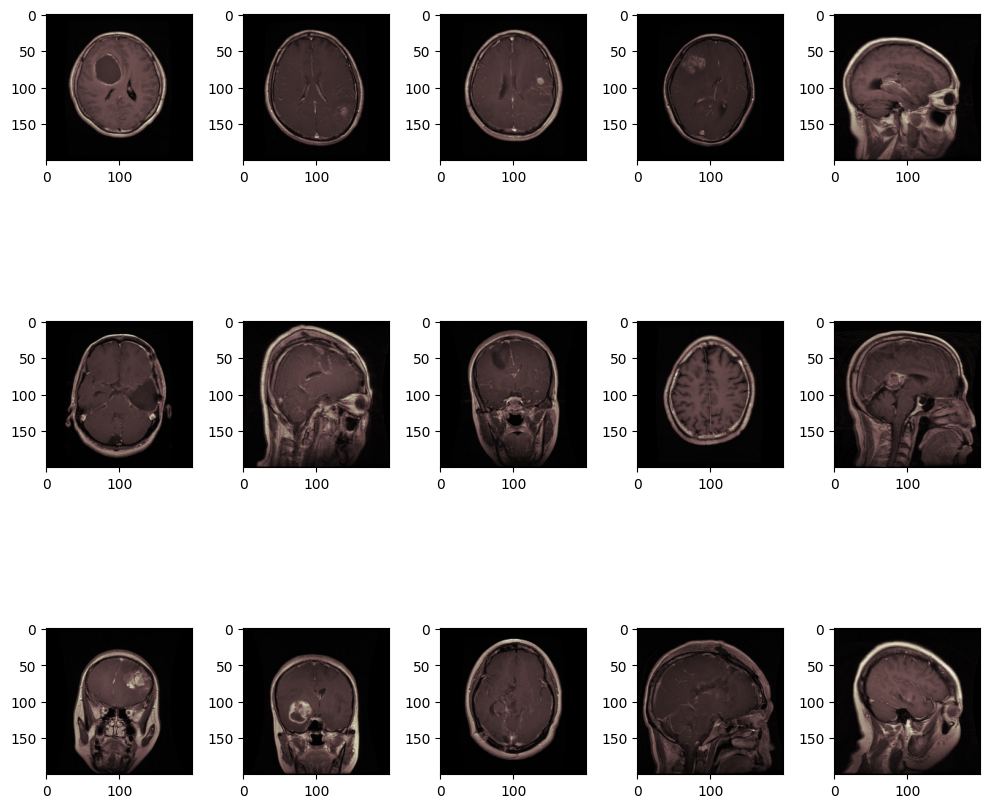

In [3]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()
     

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [5]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [6]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

2023-04-28 17:51:03.173771: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs


In [9]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 5

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/5


2023-04-28 17:51:14.152362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


229/229 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8888
Epoch 1: val_loss improved from inf to 3.09590, saving model to model-01-0.23-3.10.h5
229/229 [==============================] - 730s 3s/step - loss: 0.2953 - accuracy: 0.8888 - val_loss: 3.0959 - val_accuracy: 0.2318 - lr: 1.0000e-04
Epoch 2/5
229/229 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9562
Epoch 2: val_loss did not improve from 3.09590
229/229 [==============================] - 695s 3s/step - loss: 0.1210 - accuracy: 0.9562 - val_loss: 3.2592 - val_accuracy: 0.2817 - lr: 1.0000e-04
Epoch 3/5
229/229 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9691
Epoch 3: val_loss did not improve from 3.09590
229/229 [==============================] - 693s 3s/step - loss: 0.0882 - accuracy: 0.9691 - val_loss: 3.7909 - val_accuracy: 0.2843 - lr: 1.0000e-04
Epoch 4/5
229/229 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9779
Epo

## evaluating baseline

41/41 [==============================] - 34s 831ms/step - loss: 0.3541 - accuracy: 0.8886


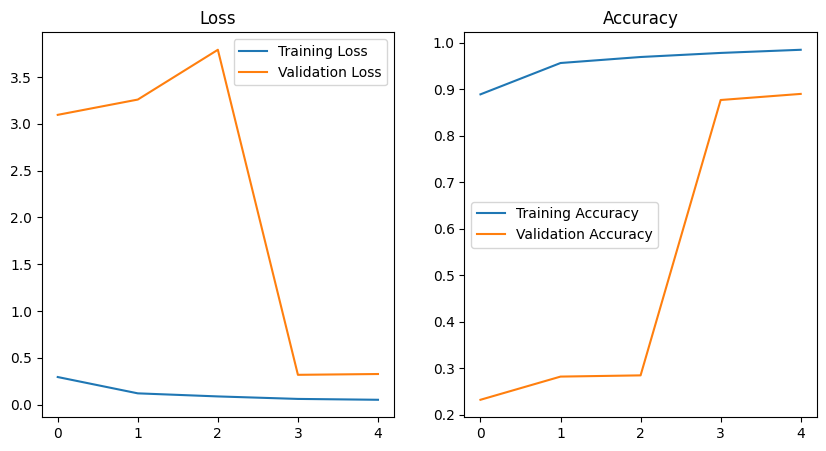

In [10]:

# Extract the trained model from the history object
model = history.model

# Evaluate your model on the test set
eval_metrics = model.evaluate(x_test, y_test)

# Extract the evaluation metrics
loss = eval_metrics[0]
accuracy = eval_metrics[1]

# Plot the evaluation metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

41/41 [==============================] - 35s 843ms/step


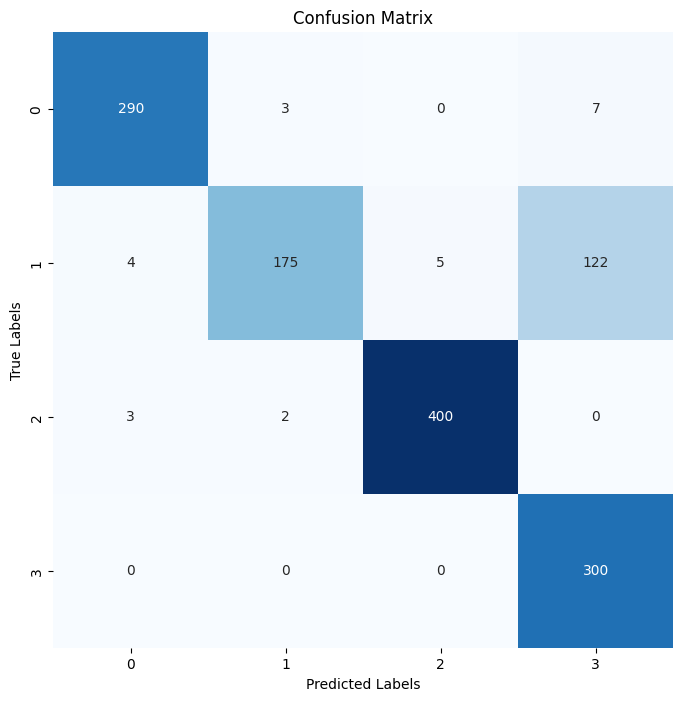

In [11]:
# Extract the predicted labels
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()